# Creating the Chronos class

There should be a few specs for this method:

* Should have a scikit-learn like interface (fit, predict)
* Should have support for MLE, MAP, MCMC, and SVI
* Parameters should be easy to grab
* Should support arbitrary residual distributions
* Should support censored data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
my_ts_data = pd.read_csv('data/prophetData.csv')
my_ts_data['ds'] = pd.to_datetime(my_ts_data['ds'])
my_ts_data.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [3]:
my_ts_data.shape

(2905, 2)

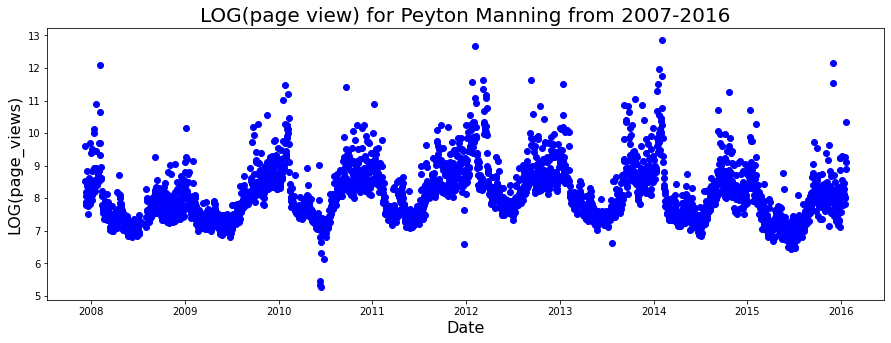

In [4]:
plt.figure(figsize=(15,5))
plt.scatter(my_ts_data['ds'], my_ts_data['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("LOG(page_views)", size=16)
plt.title(f"LOG(page view) for Peyton Manning from 2007-2016", size=20)
plt.savefig("Time Series v1 t-distribution.png", dpi=96*4)
plt.show()

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

import torch
from torch.optim import SGD, Rprop
import pyro
import pyro.distributions as dist


# We will use Markov Chain Monte Carlo (MCMC) methods here, specifically the No U-Turn Sampler (NUTS)
from pyro.infer import MCMC, NUTS
from pyro.optim import ExponentialLR
from pyro.infer import SVI, Trace_ELBO, Predictive, JitTrace_ELBO
from pyro.infer.autoguide import AutoDelta

from torch.distributions import constraints

import warnings
import logging

pyro.enable_validation(False)
pyro.enable_validation(True)

torch.set_default_tensor_type(torch.FloatTensor)
class Chronos:
    
    
    def __init__(self, 
                 method="MLE", 
                 time_col = "ds",
                 target_col="y", 
                 year_seasonality_order=10,
                 month_seasonality_order=5,
                 weekly_seasonality_order=3,
                 learning_rate=0.01,
                 max_iter=1000):
        
        self.method_ = method
        self.n_iter_ = max_iter
        self.lr_ = learning_rate
        
        
        self.year_seasonality_order_ = year_seasonality_order
        self.weekly_seasonality_order_ = weekly_seasonality_order
        self.month_seasonality_order_ = month_seasonality_order
        
        self.time_col_ = time_col
        self.target_col_ = target_col
        
        
        
    def transform_data_(self, data):
        '''
            A function to grab the raw data with a timestamp and a target column and
            add seasonality to the data using sine and cosine combinations.
        '''
        # make a copy to avoid side effects of changing the origina df
        # and convert datetime column into time in days. This helps convergence
        # BY A LOT
        internal_data = data.copy()
        internal_data['weekday'] = internal_data[self.time_col_].dt.dayofweek
        internal_data['monthday'] = internal_data[self.time_col_].dt.day - 1      # make days start at 0
        internal_data['yearday'] = internal_data[self.time_col_].dt.dayofyear - 1 # make days start at 0
        #display(internal_data)
        
        internal_data[self.time_col_] = internal_data[self.time_col_].values.astype(float)/(1e9*60*60*24)
        
        
        # Yearly seasonality 
        for i in range(1, self.year_seasonality_order_+1):
            cycle_position = i*2*math.pi*internal_data['yearday']/366 # max value will be 365
                                                                      # since values will go from 0-365
            internal_data[f"yearly_sin_{i}"] = np.sin(cycle_position) 
            internal_data[f"yearly_cos_{i}"] = np.cos(cycle_position)
        
        
        # Monthly seasonality
        for i in range(1, self.month_seasonality_order_+1):
            cycle_position = i*2*math.pi*internal_data['monthday']/31 # max value will be 30 since values
                                                                      # will go from 0 to 30
            internal_data[f"monthly_sin_{i}"] = np.sin(cycle_position) 
            internal_data[f"monthly_cos_{i}"] = np.cos(cycle_position)
        
        # Weekly seasonality
        for i in range(1, self.weekly_seasonality_order_+1):
            cycle_position = i*2*math.pi*internal_data['weekday']/7 # max value will be 6 since values
                                                                    # will go from 0 to 6
            internal_data[f"weekly_sin_{i}"] = np.sin(cycle_position) 
            internal_data[f"weekly_cos_{i}"] = np.cos(cycle_position) 
                                                                      
        
        # Add a constant so we can train a simple vector of coefficients
        internal_data.insert(0, "CONST", 1.0)
        
        internal_data = internal_data.drop(['weekday', 'monthday', 'yearday'], axis=1)
        
        
        #assert(False)
        return internal_data
        
        
        
        
    def fit(self, data):
        '''
            Fits the model to the data using the method specified.
        '''
        
        # Make a copy of the history
        self.history = data.copy()
        
        # Transform the data by adding seasonality
        internal_data = self.transform_data_(data)
        
        # Split the data into X features (all time related features), and 
        # the target y
        
        y = torch.tensor(internal_data[self.target_col_].values, dtype=torch.float32)
        
        internal_data = internal_data.drop(self.target_col_, axis=1)
        X = torch.tensor(internal_data.values, dtype=torch.float32)
        self.X_names = internal_data.columns.values
        
        
        
        if (self.method_ in ["MLE", "MAP"]):        # Point estimate methods
            if (self.method_ == "MLE"):
                print("Employing Maximum Likelihood Estimation")
                self.model = self.model_MLE_
                self.guide = self.guide_MLE_
                
            elif (self.method_ == "MAP"):
                print("Employing Maximum A Posteriori")
                self.model = self.model_MAP_
                self.guide = AutoDelta(self.model)
                
            # This raises a trace warning so we turn that off. 
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                self.train_point_estimate(self.model, 
                                          self.guide,
                                          X,
                                          y)
        elif (self.method == "MCMC"):
            print("Employing Markov Chain Monte Carlo")
        
            
            
    ##################################################################
    def train_MCMC(self, model, X, y, sample_num = 3000):
        pass
    
    ##################################################################
    def train_point_estimate(self, model, guide, X, y):
        
        pyro.clear_param_store()
        
        optimizer = Rprop
        scheduler = pyro.optim.ExponentialLR({'optimizer': optimizer, 
                                              'optim_args': {'lr': self.lr_}, 
                                              'gamma': 0.1})
        
        self.svi_ = SVI(model, 
                        guide, 
                        scheduler, 
                        loss=JitTrace_ELBO())
        
        
        print_interval = max(self.n_iter_//10000, 10)
        
        for step in range(self.n_iter_):
            
            loss = round(self.svi_.step(X, y)/y.shape[0], 4)
            
            if (step % print_interval == 0):
                pct_done = round(100*(step+1)/self.n_iter_, 2)
                
                print(" "*100, end="\r")
                print(f"{pct_done}% - ELBO loss: {loss}", end="\r")
        
        pct_done = round(100*(step+1)/self.n_iter_, 2)
        print(" "*100, end="\r")
        print(f"{pct_done}% - ELBO loss: {loss}", end="\r")
            
    ##################################################################
    
    def model_MLE_(self, X, y=None):            
        #mu = 0
        #for i in range(0, X.size(1)):
        #    beta_1 = pyro.param(f"beta_{self.X_names[i]}", torch.tensor(0.0))
        #    
        #    mu += (beta_1 * X[:, i])
        betas = pyro.param(f"betas", torch.zeros(X.size(1)))
        #betas = betas.view(-1,1)
        
        mu = X.matmul(betas)
            
        
        sigma = pyro.param("sigma", 
                           torch.tensor(1.0), 
                           constraint = constraints.positive)
         
        
        with pyro.plate("data", X.size(0)):
            pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
            
        return mu
        
        
    
    def guide_MLE_(self, X, y=None):
        pass
    
    
    ##################################################################
    
    def model_MAP_(self, X, y=None):
        
        
        betas = pyro.sample(f"betas", dist.Normal(torch.zeros(X.size(1)), 
                                                  torch.full((X.size(1),), 10.0)).to_event(1))
        
        mu = X.matmul(betas)

        
        
        sigma = pyro.sample("sigma", dist.HalfCauchy(1.0))
        df = pyro.sample("df", dist.HalfCauchy(1.0))
         
        
        with pyro.plate("data", X.size(0)):
            #pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
            pyro.sample("obs", dist.StudentT(df, mu, sigma), obs=y)
            
        return mu
    
    
    def model_MAP_gamma(self, X, y=None):
        
        betas = pyro.sample(f"betas", dist.Normal(torch.zeros(X.size(1)), 
                                                  torch.full((X.size(1),), 10.0)).to_event(1))
        
        linear_combo = X.matmul(betas)
        
        mu = linear_combo.clamp(min=torch.finfo(torch.float32).eps)
            
        
        
        rate = pyro.sample("rate", dist.HalfCauchy(1.0)).clamp(min=torch.finfo(torch.float32).eps)
        shape = mu * rate
         
        #print(shape, rate)
        
        
        with pyro.plate("data", X.size(0)):
            pyro.sample('obs', dist.Gamma(shape, rate), obs=y)
            
        return mu
        
    
    ##################################################################
    def predict(self, data, sample_number=100, ci_interval=0.95):
        internal_data = self.transform_data_(data)
        #display(internal_data)
        
        
        y = torch.tensor(internal_data[self.target_col_].values, dtype=torch.float32)
        
        internal_data = internal_data.drop(self.target_col_, axis=1)
        X = torch.tensor(internal_data.values, dtype=torch.float32)

        
        if (self.method_ in ["MAP", "MLE"]):
            # https://pyro.ai/examples/bayesian_regression.html#Model-Evaluation
            predictive = Predictive(model=self.model,
                                    guide=self.guide,
                                    num_samples=sample_number,
                                    return_sites=("obs",)) 

            samples = predictive(X)
            
            
            space_on_each_side = (1.0 - ci_interval)/2.0
            lower_ntile = int(len(samples['obs']) * space_on_each_side)
            upper_ntile = int(len(samples['obs']) * (1.0 - space_on_each_side))
            
            predictions = pd.DataFrame({"yhat": torch.mean(samples['obs'], 0).detach().numpy(),
                                        "yhat_lower": samples['obs'].kthvalue(lower_ntile, dim=0)[0].detach().numpy(),
                                        "yhat_upper": samples['obs'].kthvalue(upper_ntile, dim=0)[0].detach().numpy()})
            
            predictions['y'] = y.detach().numpy()
            predictions[self.time_col_] = data[self.time_col_]
            return predictions[[self.time_col_, 'y', 'yhat', 'yhat_upper', 'yhat_lower']]
        else:
            raise NotImplementedError(f"Did not implement .predict for {self.method_}")

        
        
        
    ##################################################################
    def make_future_dataframe(self, period=30, frequency="D", include_history=True):
        '''
            Creates a future dataframe based on the specified parameters.
            
            Parameters:
            ------------
            [period] - int : The number of rows of future data to predict
            
        '''
        max_date_observed = self.history[self.time_col_].max()
        
        date_range = pd.date_range(start=str(max_date_observed), periods=period+1, freq=frequency)
        date_range = date_range[1:]
        
        future_df = pd.DataFrame({self.time_col_: date_range,
                                  self.target_col_: [np.nan] * date_range.shape[0]})
        
        past_df = self.history.copy()
        future_df = pd.concat([past_df, future_df], axis=0).reset_index(drop=True)

        return future_df
    
    ##################################################################
    def get_trend(self):
        pass
    ##################################################################
    def get_weekly_seasonality(self):
        if (self.method_ == "MAP"):
            return self.get_weekly_seasonality_point('AutoDelta.betas')
        elif (self.method_ == "MLE"):
            return self.get_weekly_seasonality_point('betas')
        else:
            raise NotImplementedError("Did not implement weekly seasonality for non MAP non MLE")
    ##################################################################
    def get_weekly_seasonality_point(self, param_name):

        weekly_params = []
        for i, param in enumerate(pyro.param(param_name)):
            if ("weekly" in self.X_names[i]):
                weekly_params.append(param.item())
                
        weekly_params = np.array(weekly_params).reshape(-1, 2)
        
        weekdays = np.arange(0, 7, 1)
        seasonality = np.zeros_like(weekdays, dtype=np.float64)
        
        for i, pair in enumerate(weekly_params):
            cycle_order = i+1
            sin_coef = pair[0]
            cosin_coef = pair[1]
            
            cycle_pos = cycle_order * 2 * math.pi * weekdays/7
            seasonality += (sin_coef * np.sin(cycle_pos)) + (cosin_coef * np.cos(cycle_pos))
            
            
        weekly_seasonality = pd.DataFrame({"Weekday": weekdays,
                                           "Value": seasonality})
        
        return weekly_seasonality
    
    ##################################################################
    def plot_weekly_seasonality(self):
        weekly_seasonality = self.get_weekly_seasonality()
        plt.figure(figsize=(15,5))
        plt.plot(weekly_seasonality['Weekday'], weekly_seasonality['Value'])
        plt.axhline(0.0, c="black")
        plt.xlim(0.0, 6.0)
        plt.show();
    ##################################################################
    def get_monthly_seasonality(self):
        if (self.method_ == "MAP"):
            return self.get_monthly_seasonality_point('AutoDelta.betas')
        elif (self.method_ == "MLE"):
            return self.get_monthly_seasonality_point('betas')
        else:
            raise NotImplementedError("Did not implement monthly seasonality for non MAP non MLE")
    ##################################################################
    def get_monthly_seasonality_point(self, param_name):

        monthly_params = []
        
        for i, param in enumerate(pyro.param(param_name)):
            if ("monthly" in self.X_names[i]):
                monthly_params.append(param.item())
                
        monthly_params = np.array(monthly_params).reshape(-1, 2)
        
        monthdays = np.arange(0, 32, 1)
        seasonality = np.zeros_like(monthdays, dtype=np.float64)
        
        for i, pair in enumerate(monthly_params):
            cycle_order = i+1
            sin_coef = pair[0]
            cosin_coef = pair[1]
            
            cycle_pos = cycle_order * 2 * math.pi * monthdays/30
            seasonality += (sin_coef * np.sin(cycle_pos)) + (cosin_coef * np.cos(cycle_pos))
            
            
        monthly_seasonality = pd.DataFrame({"Monthday": monthdays+1,
                                            "Value": seasonality})
        
        return monthly_seasonality
    ##################################################################
    def plot_monthly_seasonality(self):
        monthly_seasonality = self.get_monthly_seasonality()
        plt.figure(figsize=(15,5))
        plt.plot(monthly_seasonality['Monthday'], monthly_seasonality['Value'])
        plt.axhline(0.0, c="black")
        plt.xlim(1.0, 30.0)
        plt.show();
    ##################################################################
    def get_yearly_seasonality(self):
        if (self.method_ == "MAP"):
            return self.get_yearly_seasonality_point('AutoDelta.betas')
        elif (self.method_ == "MLE"):
            return self.get_yearly_seasonality_point('betas')
        else:
            raise NotImplementedError("Did not implement yearly seasonality for non MAP non MLE")
    ##################################################################
    def get_yearly_seasonality_point(self, param_name):

        yearly_params = []

        for i, param in enumerate(pyro.param(param_name)):
            if ("yearly" in self.X_names[i]):
                yearly_params.append(param.item())
                                
        yearly_params = np.array(yearly_params).reshape(-1, 2)
        
        yeardays = np.arange(0, 366, 1)
        seasonality = np.zeros_like(yeardays, dtype=np.float64)
        
        for i, pair in enumerate(yearly_params):
            cycle_order = i+1
            sin_coef = pair[0]
            cosin_coef = pair[1]
            
            cycle_pos = cycle_order * 2 * math.pi * yeardays/366
            seasonality += (sin_coef * np.sin(cycle_pos)) + (cosin_coef * np.cos(cycle_pos))
            
            
        yearly_seasonality = pd.DataFrame({"Yearday": yeardays+1,
                                           "Value": seasonality})
        
        return yearly_seasonality
    
    ##################################################################
    def plot_yearly_seasonality(self):
        yearly_seasonality = self.get_yearly_seasonality()
        plt.figure(figsize=(15,5))
        plt.plot(yearly_seasonality['Yearday'], yearly_seasonality['Value'])
        plt.axhline(0.0, c="black")
        plt.xlim(1.0, 366.0)
        plt.show();

    

In [6]:
my_chronos = Chronos(method="MAP", max_iter=1000, learning_rate=0.1)
my_chronos.fit(my_ts_data)

Employing Maximum A Posteriori


In [7]:
future_df = my_chronos.make_future_dataframe(period=365)
future_df

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572
...,...,...
3265,2017-01-15,NaN
3266,2017-01-16,NaN
3267,2017-01-17,NaN
3268,2017-01-18,NaN


In [8]:
predictions = my_chronos.predict(future_df, sample_number=1000)

0.4301583469705615


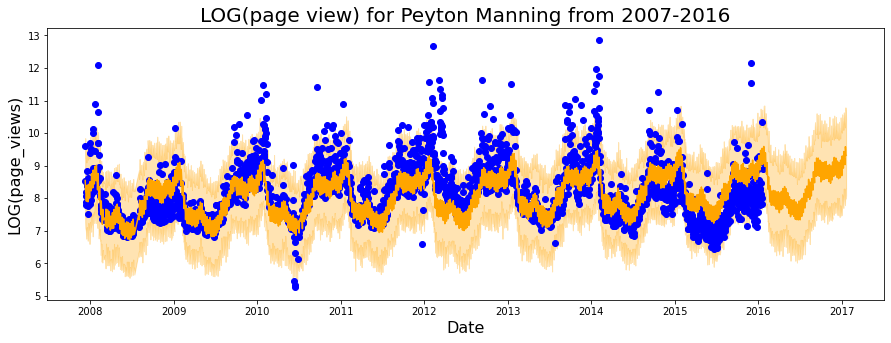

In [9]:
from sklearn.metrics import mean_absolute_error

MAE = np.mean(np.abs(future_df['y'] - predictions['yhat']))
print(MAE)

plt.figure(figsize=(15,5))
plt.plot(future_df['ds'], predictions['yhat'], c="orange")
plt.fill_between(future_df['ds'], predictions['yhat_upper'], predictions['yhat_lower'], color="orange", alpha=0.3)
plt.scatter(future_df['ds'], future_df['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("LOG(page_views)", size=16)
plt.title(f"LOG(page view) for Peyton Manning from 2007-2016", size=20)
plt.savefig("Time Series v1 t-distribution.png", dpi=96*4)
plt.show()

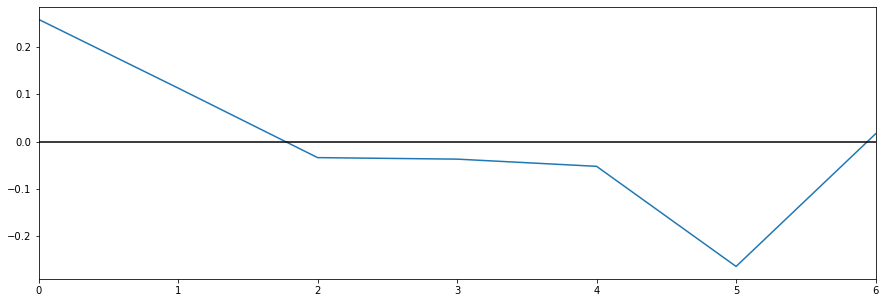

In [10]:
my_chronos.plot_weekly_seasonality()

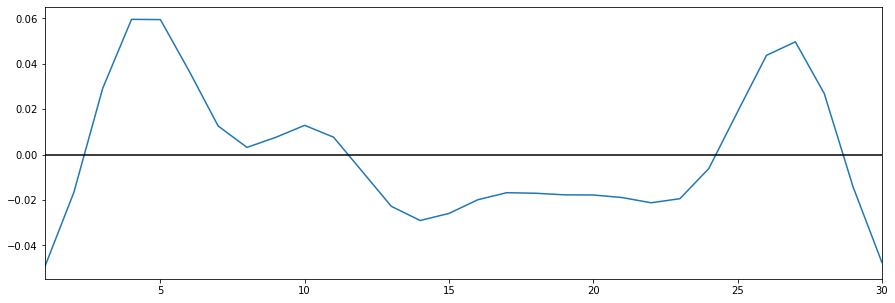

In [11]:
my_chronos.plot_monthly_seasonality()

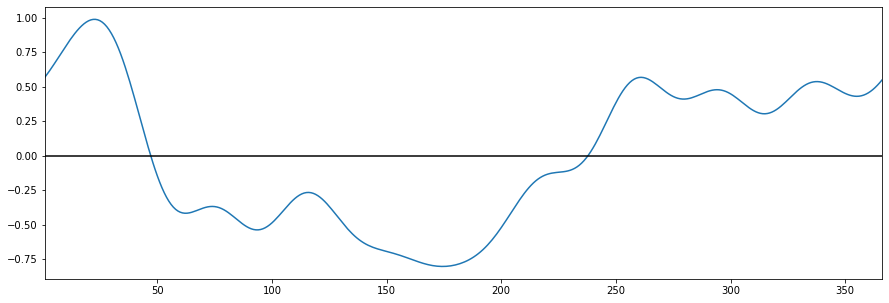

In [12]:
my_chronos.plot_yearly_seasonality()

## MLE method instead

In [13]:
my_chronos = Chronos(method="MLE", max_iter=1000, learning_rate=0.01)
my_chronos.fit(my_ts_data)

Employing Maximum Likelihood Estimation


In [14]:
future_df = my_chronos.make_future_dataframe(period=365)
future_df

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572
...,...,...
3265,2017-01-15,NaN
3266,2017-01-16,NaN
3267,2017-01-17,NaN
3268,2017-01-18,NaN


In [15]:
predictions = my_chronos.predict(future_df, sample_number=1000)

0.4576054105674955


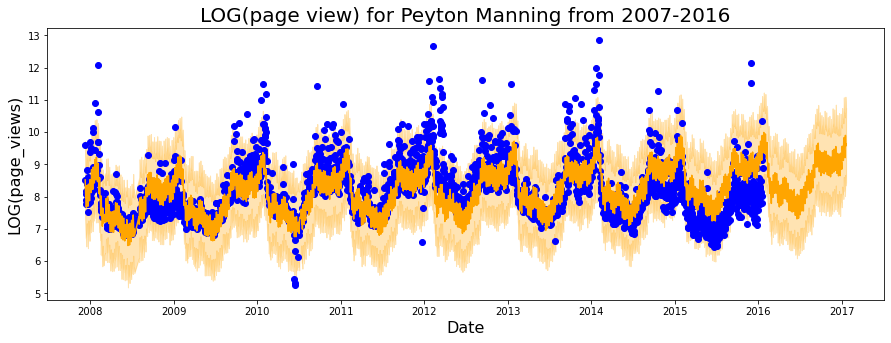

In [16]:
MAE = np.mean(np.abs(future_df['y'] - predictions['yhat']))
print(MAE)

plt.figure(figsize=(15,5))
plt.plot(future_df['ds'], predictions['yhat'], c="orange")
plt.fill_between(future_df['ds'], predictions['yhat_upper'], predictions['yhat_lower'], color="orange", alpha=0.3)
plt.scatter(future_df['ds'], future_df['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("LOG(page_views)", size=16)
plt.title(f"LOG(page view) for Peyton Manning from 2007-2016", size=20)
plt.savefig("Time Series v1 t-distribution.png", dpi=96*4)
plt.show()

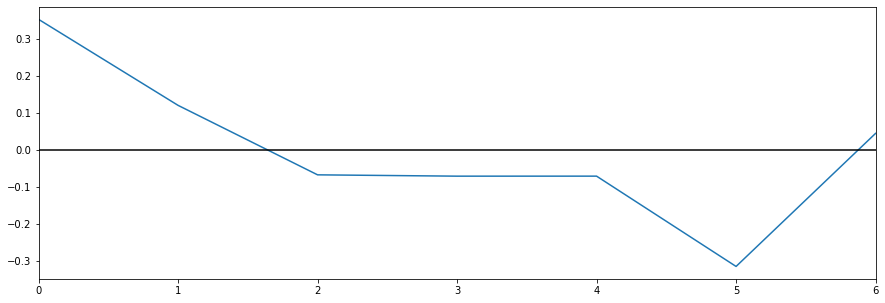

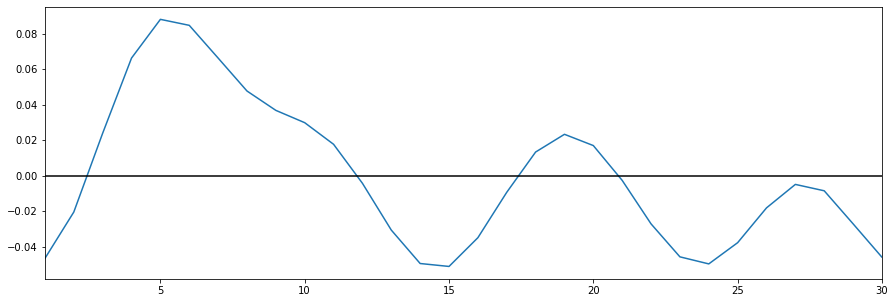

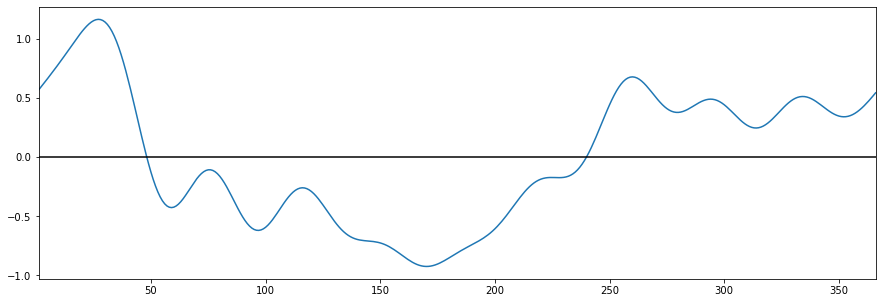

In [17]:
my_chronos.plot_weekly_seasonality()
my_chronos.plot_monthly_seasonality()
my_chronos.plot_yearly_seasonality()